In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
# read dir and search for WHITE, DARK and OBJECT (RAW and HDR)
def readDir(dir_path):
    myDir = os.listdir(dir_path)
    dark_hdr =[]
    dark_raw=[]
    white_hdr=[]
    white_raw=[]
    for file in myDir:
        if 'dark' in file.lower() and 'hdr' in file.lower():
            #dark_hdr = dir_path + '/' + file
            dark_hdr = os.path.join(dir_path, file)
        if 'dark' in file.lower() and 'raw' in file.lower():
            #dark_raw = dir_path + '/' + file
            dark_raw = os.path.join(dir_path, file)
        if 'white' in file.lower() and 'hdr' in file.lower():
            #white_hdr = dir_path + '/' + file
            white_hdr = os.path.join(dir_path, file)
        if 'white' in file.lower() and 'raw' in file.lower():
            #white_raw = dir_path + '/' + file
            white_raw = os.path.join(dir_path, file)
        if (not 'white' in file.lower()) and (not 'dark' in file.lower()) and 'hdr' in file.lower():
            #object_hdr = dir_path + '/' + file
            object_hdr = os.path.join(dir_path, file)
        if (not 'white' in file.lower()) and (not 'dark' in file.lower()) and 'raw' in file.lower():
            #object_raw = dir_path + '/' + file
            object_raw = os.path.join(dir_path, file)
    return object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr  


# Read HDR content
def read_hdr(hdr_path):
    f=open(hdr_path, "r")
    filelines = f.readlines()
    f.close()
    bands = ''
    for fileline in filelines:
        if 'samples' in fileline.lower():
            samples = int(fileline.replace('samples = ',''))
        if bands =='' and 'bands' in fileline.lower():
            bands = int(fileline.replace('bands = ',''))
        if 'lines' in fileline.lower():
            lines = int(fileline.replace('lines = ',''))   
    n = 0
    for fileline in filelines:
        if 'th = {' in fileline.lower():
          n1 = n+1
        n = n + 1
    n2 = n1 + bands
    waves = np.zeros(n2-n1)
    n = 0
    for i in range(n1, n2):
        waves[n] = float(filelines[i].replace(',',''))
        n = n + 1
    
    return samples, bands, lines, waves     

./vis_green_samples/capture/vis_scan_0103.raw
spectral_image.shape:  (2564, 135, 2144)


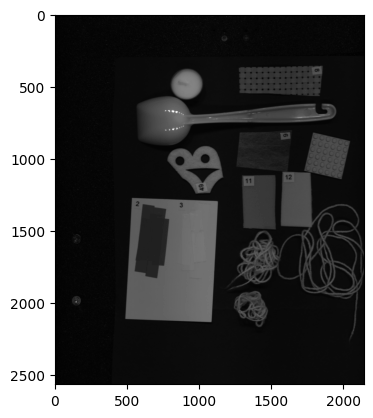

In [2]:
# Read main object 
path = "./vis_green_samples/capture/"

[object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr ] = readDir(path)
print(object_raw)
[samples, bands, lines, waves] = read_hdr(object_hdr)

#open_path = object_raw
# Read raw ###############################################
fopen = open(object_raw, "rb")
raw_image = np.fromfile(fopen, dtype=np.uint16)  #uint16 float32 #count=spatial_pixels*sample_lines*spectral_bands
spectral_cube = np.reshape(raw_image, (lines, bands, samples))
print('spectral_image.shape: ', spectral_cube.shape)
plt.rcParams['figure.dpi'] = 100 # Resolution
plt.imshow(spectral_cube[:,100,:], cmap='gray') # show gray scale slice of 3D spectral image
plt.show()





Band 60 wavelength 620.18
Band 46 wavelength 549.71
Band 24 wavelength 440.6


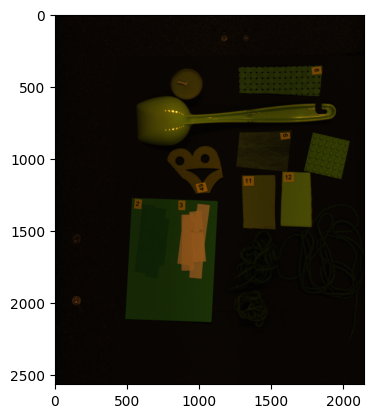

In [6]:
RGB = np.empty((lines, samples, 3)) 
w1,w2,w3 = 620,550,440
ch_1 = np.abs(np.asarray(waves)-w1).argmin() 
ch_2 = np.abs(np.asarray(waves)-w2).argmin()
ch_3 = np.abs(np.asarray(waves)-w3).argmin()

print('Band',ch_1,'wavelength', waves[ch_1])
print('Band',ch_2,'wavelength', waves[ch_2])
print('Band',ch_3,'wavelength', waves[ch_3])

RGB[:,:,0] = spectral_cube[:,ch_1,:] /np.amax(spectral_cube[:,ch_1,:]) # we get RGB in range [0,1], normalized
RGB[:,:,1] = spectral_cube[:,ch_2,:] /np.amax(spectral_cube[:,ch_2,:])
RGB[:,:,2] = spectral_cube[:,ch_3,:] /np.amax(spectral_cube[:,ch_3,:])

# RGB[:,:,0] = spectral_image[:,ch_1,:] 
# RGB[:,:,1] = spectral_image[:,ch_2,:] 
# RGB[:,:,2] = spectral_image[:,ch_3,:] 



plt.imshow(RGB)
plt.show()

./vis_green_samples/capture/WHITEREF_vis_scan_0103.hdr
275 135 2144


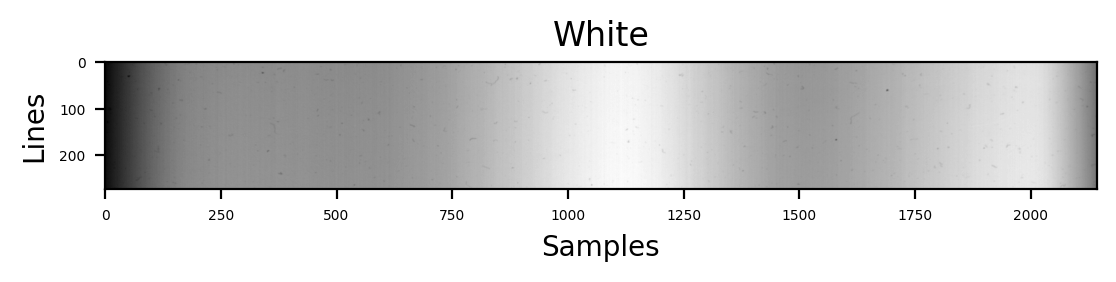

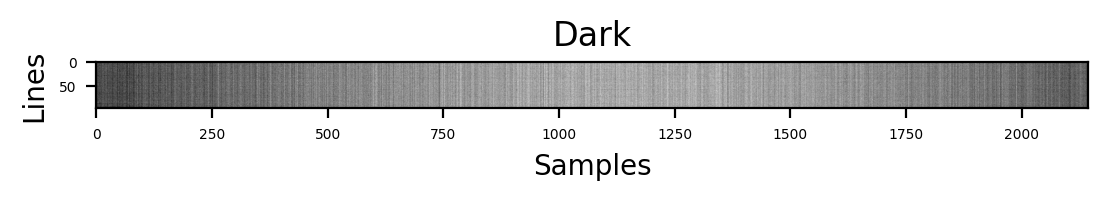

In [7]:
print(white_hdr)
[samples, bands, lines, waves] = read_hdr(white_hdr)
print(lines, bands, samples)
open_path = white_raw
fopen = open(open_path, "rb")
raw_image = np.fromfile(fopen, dtype=np.uint16) #uint16 float32 #count=spatial_pixels*sample_lines*spectral_bands
white_image = np.reshape(raw_image, (lines, bands, samples))/lines
plt.rcParams['figure.dpi'] = 200
plt.imshow(white_image[:,50,:], cmap="gray")# , vmin=0, vmax=60500
plt.title("White")
plt.xlabel('Samples')
plt.ylabel('Lines')
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

# Read Dark ###############################################
[samples, bands, lines, waves] = read_hdr(dark_hdr)
open_path = dark_raw
fopen = open(open_path, "rb")
raw_image = np.fromfile(fopen, dtype=np.uint16) #uint16 float32 #count=spatial_pixels*sample_lines*spectral_bands
dark_image = np.reshape(raw_image, (lines, bands, samples))/lines
plt.rcParams['figure.dpi'] = 200
plt.imshow(dark_image[:,20,:], cmap="gray")#, vmin=0, vmax=10
plt.title("Dark")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('Samples')
plt.ylabel('Lines')
plt.show()

(2564, 135, 2144)


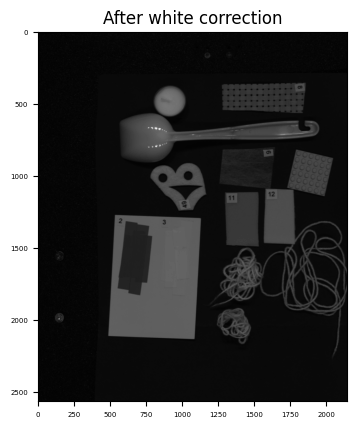

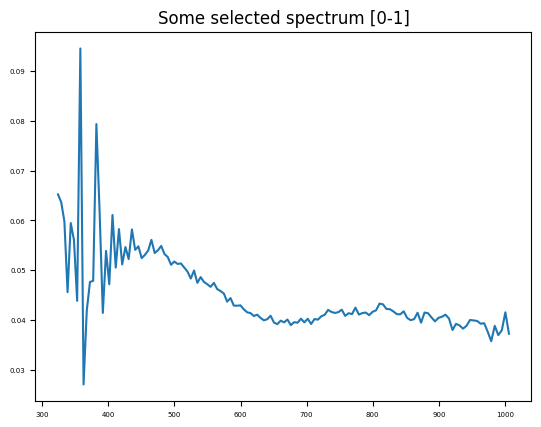

In [11]:
white_av = np.sum(white_image, axis = 0) # get average for White
dark_av = np.sum(dark_image, axis = 0) # get average for Dark

[lines, bands, samples] = spectral_cube.shape
print(spectral_cube.shape)
upper_part = np.zeros((lines, bands, samples), dtype=np.float32)
spectral_cube = np.zeros((lines, bands, samples), dtype=np.float32)
# Subtract [image - dark]
for i in range(lines):
  upper_part[i,:,:] = np.subtract(spectral_cube[i,:,:], dark_av) 
# Subtract [white - dark]
lower_part = np.subtract(white_av, dark_av) 
# Subtract [image devide [white-dark]]
for i in range(lines):
  spectral_cube[i,:,:] = np.divide(upper_part[i,:,:], lower_part)
# spectral_cube[:,:,:]  a white corrected spectral cube

plt.imshow(5*spectral_cube[:,100,:], cmap="gray")#, vmin=0, vmax= 1
plt.title("After white correction")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()
plt.plot(waves, spectral_cube[150,:,150])#
plt.title("Some selected spectrum [0-1]")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

Band 62 wavelength 630.31
Band 42 wavelength 529.72
Band 25 wavelength 445.52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


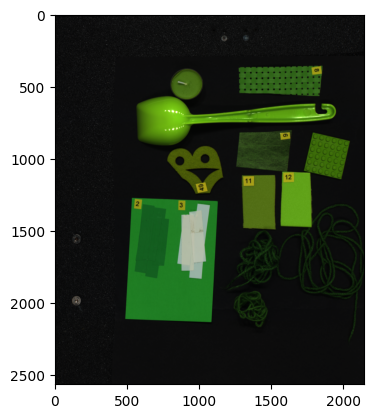

In [12]:
[s1,s2,s3] = spectral_cube.shape
RGBw = np.empty((s1, s3, 3)) # Create a 'bmp' array with spatial size of ENVI 512,512 with 3 layers
# We go to hdr file and select channels

w1,w2,w3 = 630,530,445
ch_1 = np.abs(np.asarray(waves)-w1).argmin() 
ch_2 = np.abs(np.asarray(waves)-w2).argmin()
ch_3 = np.abs(np.asarray(waves)-w3).argmin()

print('Band',ch_1,'wavelength', waves[ch_1])
print('Band',ch_2,'wavelength', waves[ch_2])
print('Band',ch_3,'wavelength', waves[ch_3])

RGBw[:,:,0] = spectral_cube[:,ch_1,:] 
RGBw[:,:,1] = spectral_cube[:,ch_2,:]
RGBw[:,:,2] = spectral_cube[:,ch_3,:]
plt.rcParams['figure.dpi'] = 100
plt.imshow(RGBw)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


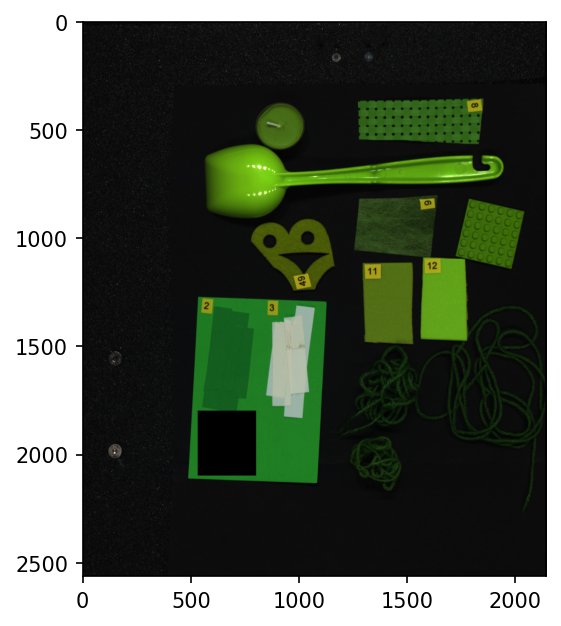

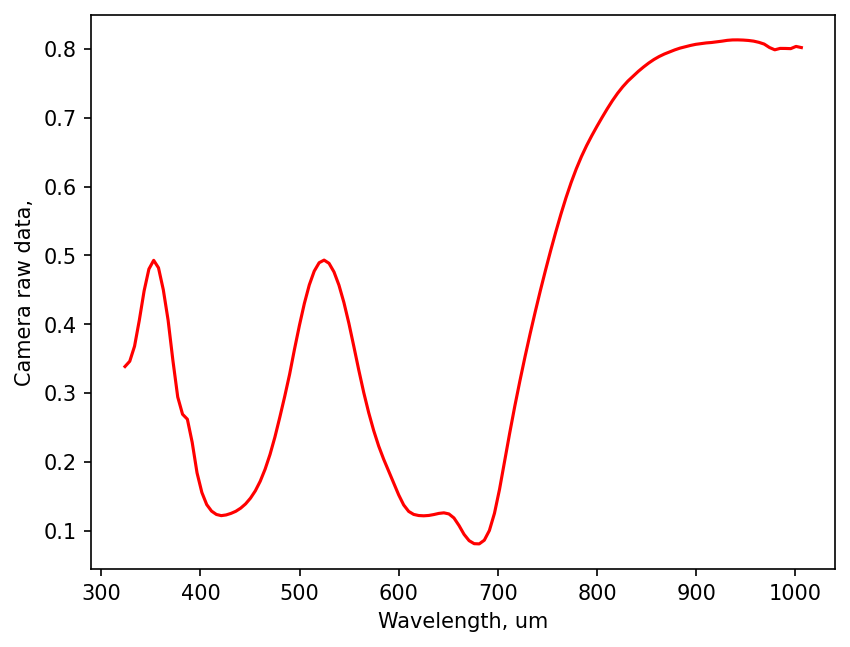

(2564, 135, 2144)


In [17]:
RGBm = RGBw.copy()
x1 = 530
x2 = 800
y1 = 1800
y2 = 2100
RGBm[y1:y2,x1:x2,0] = 0
RGBm[y1:y2,x1:x2,1] = 0
RGBm[y1:y2,x1:x2,2] = 0
sel = spectral_cube[y1:y2,:,x1:x2]
sel1 = np.sum(sel, axis = 0)
sample = np.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
##################################################################
plt.rcParams['figure.dpi'] = 150
plt.imshow(RGBm)
plt.show()



plt.plot(waves, sample, "red")
plt.rcParams['figure.dpi'] = 100
plt.xlabel('Wavelength, um')
plt.ylabel('Camera raw data,')
#plt.ylabel('Reflectance [0-100]%')
plt.show()
print(spectral_cube.shape)

2564 135 2144
46
56
66
76
85
95
105
RGB:  (2564, 2144, 3)
cube:  (2564, 135, 2144)
small cube:  (2564, 2144, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2.7487013
3.8856340646743774
7.449232578277588


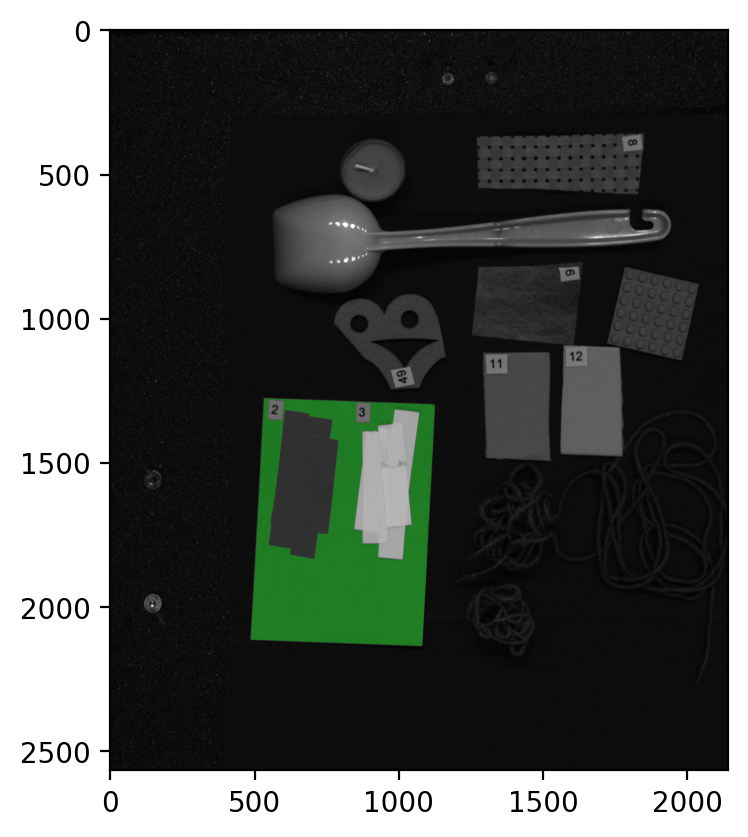

In [20]:
# Generate Band based condition
n = 7 # the number of important bnds
bands = np.empty(n, dtype=np.uint16) # array size of number of important bands
# we select the importqant bands:
w1=550
w2=600
w3=650
w4=700
w5=750
w6=800
w7=850
bands[0] = np.abs(np.asarray(waves)-w1).argmin() 
bands[1] = np.abs(np.asarray(waves)-w2).argmin()
bands[2] = np.abs(np.asarray(waves)-w3).argmin()
bands[3] = np.abs(np.asarray(waves)-w4).argmin() 
bands[4] = np.abs(np.asarray(waves)-w5).argmin()
bands[5] = np.abs(np.asarray(waves)-w6).argmin()
bands[6] = np.abs(np.asarray(waves)-w7).argmin()

# Read selected spectrum, ploted and saved in prevous code section 
# open_path = "/content/drive/MyDrive/mushrom_image0001.raw"
# fopen = open(open_path, "rb")
# selected = np.fromfile(fopen, dtype=np.float32) 
# fopen.close()
###################################################################################################
# ratio is an array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
ratio = np.zeros(n-1) # array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
for i in range(n-1):
  ratio[i] = sample[bands[i]]
###################################################################################################
# now we make a new 'small_spectral_cube' made of selected bands from 'spectral_cube'
[s1, s2, s3] = spectral_cube.shape
print(s1, s2, s3)
small_spectral_cube = np.empty((lines, samples, n), dtype=np.float32)
i=0
for band in bands:
  small_spectral_cube[:,:,i] = spectral_cube[:,band,:]
  print(band)
  i=i+1
print('RGB: ', RGBw.shape)
print('cube: ', spectral_cube.shape)
print('small cube: ', small_spectral_cube.shape)

###################################################################################################
mask = RGBw.copy()

for i in range(0,s1):  #s1
  for j in range(0,s3): #s3
    criteria = 0
    for ch in range(n-1):
      #mask[i,j,0]=1
      if np.abs((small_spectral_cube[i,j,ch]-ratio[ch]))>0.1: #[0.02 - 0.18] threshold
        criteria = 1
        # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
        gray_color = (mask[i,j,0] + mask[i,j,1] + mask[i,j,2])/3 # make mask gray scale and only selection RGB
        mask[i,j,0]=gray_color
        mask[i,j,1]=gray_color
        mask[i,j,2]=gray_color                       
        # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
    if criteria == 0:
      pass

print(np.amax(small_spectral_cube))
print(np.amax(mask))
print(np.amax(RGBw))
###################################################################################################
# plt.rcParams['figure.dpi'] = 200
# plt.imshow(RGBw)

plt.show()
plt.rcParams['figure.dpi'] = 200
plt.imshow(mask)

plt.show()

## Task1_part2_specim(Green_samples)

./Green samples/capture/412.raw
spectral_image.shape:  (512, 204, 512)


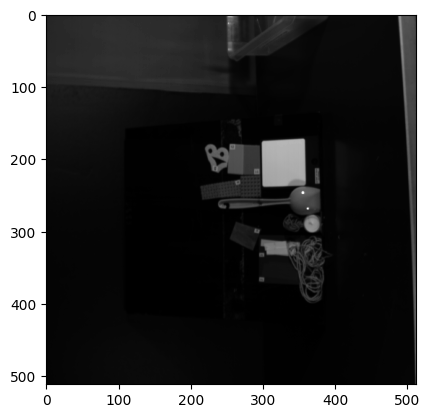

In [34]:
# Read main object 
path = "./Green samples/capture/"

[object_raw, object_hdr, white_raw, white_hdr, dark_raw, dark_hdr ] = readDir(path)
print(object_raw)
[samples, bands, lines, waves] = read_hdr(object_hdr)

#open_path = object_raw
# Read raw ###############################################
fopen = open(object_raw, "rb")
raw_image = np.fromfile(fopen, dtype=np.uint16)  #uint16 float32 #count=spatial_pixels*sample_lines*spectral_bands
spectral_cube = np.reshape(raw_image, (lines, bands, samples))
print('spectral_image.shape: ', spectral_cube.shape)
plt.rcParams['figure.dpi'] = 100 # Resolution
plt.imshow(spectral_cube[:,100,:], cmap='gray') # show gray scale slice of 3D spectral image
plt.show()





Band 76 wavelength 619.3
Band 52 wavelength 548.55
Band 15 wavelength 440.66


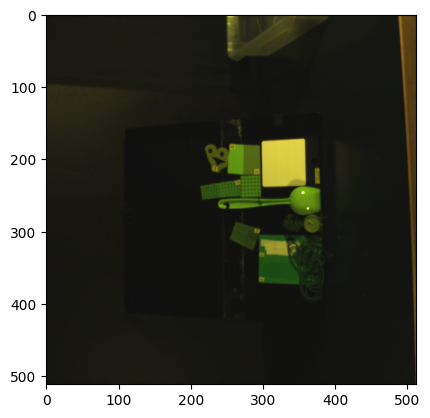

In [35]:
RGB = np.empty((lines, samples, 3)) 
w1,w2,w3 = 620,550,440
ch_1 = np.abs(np.asarray(waves)-w1).argmin() 
ch_2 = np.abs(np.asarray(waves)-w2).argmin()
ch_3 = np.abs(np.asarray(waves)-w3).argmin()

print('Band',ch_1,'wavelength', waves[ch_1])
print('Band',ch_2,'wavelength', waves[ch_2])
print('Band',ch_3,'wavelength', waves[ch_3])

RGB[:,:,0] = spectral_cube[:,ch_1,:] /np.amax(spectral_cube[:,ch_1,:]) # we get RGB in range [0,1], normalized
RGB[:,:,1] = spectral_cube[:,ch_2,:] /np.amax(spectral_cube[:,ch_2,:])
RGB[:,:,2] = spectral_cube[:,ch_3,:] /np.amax(spectral_cube[:,ch_3,:])

# RGB[:,:,0] = spectral_image[:,ch_1,:] 
# RGB[:,:,1] = spectral_image[:,ch_2,:] 
# RGB[:,:,2] = spectral_image[:,ch_3,:] 



plt.imshow(RGB)
plt.show()

./Green samples/capture/WHITEREF_412.hdr
1 204 512


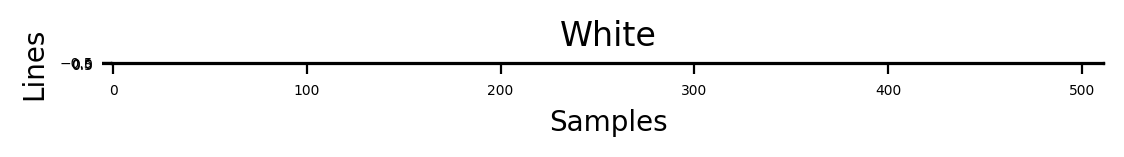

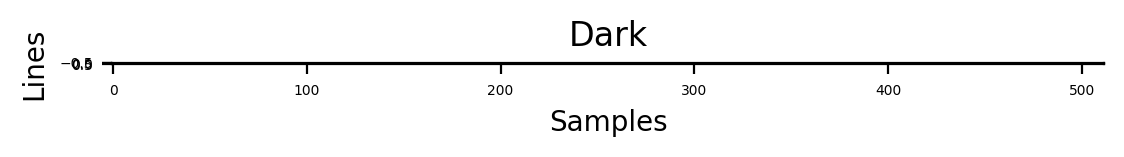

In [36]:
print(white_hdr)
[samples, bands, lines, waves] = read_hdr(white_hdr)
print(lines, bands, samples)
open_path = white_raw
fopen = open(open_path, "rb")
raw_image = np.fromfile(fopen, dtype=np.uint16) #uint16 float32 #count=spatial_pixels*sample_lines*spectral_bands
white_image = np.reshape(raw_image, (lines, bands, samples))/lines
plt.rcParams['figure.dpi'] = 200
plt.imshow(white_image[:,50,:], cmap="gray")# , vmin=0, vmax=60500
plt.title("White")
plt.xlabel('Samples')
plt.ylabel('Lines')
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

# Read Dark ###############################################
[samples, bands, lines, waves] = read_hdr(dark_hdr)
open_path = dark_raw
fopen = open(open_path, "rb")
raw_image = np.fromfile(fopen, dtype=np.uint16) #uint16 float32 #count=spatial_pixels*sample_lines*spectral_bands
dark_image = np.reshape(raw_image, (lines, bands, samples))/lines
plt.rcParams['figure.dpi'] = 200
plt.imshow(dark_image[:,20,:], cmap="gray")#, vmin=0, vmax=10
plt.title("Dark")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xlabel('Samples')
plt.ylabel('Lines')
plt.show()

(512, 204, 512)


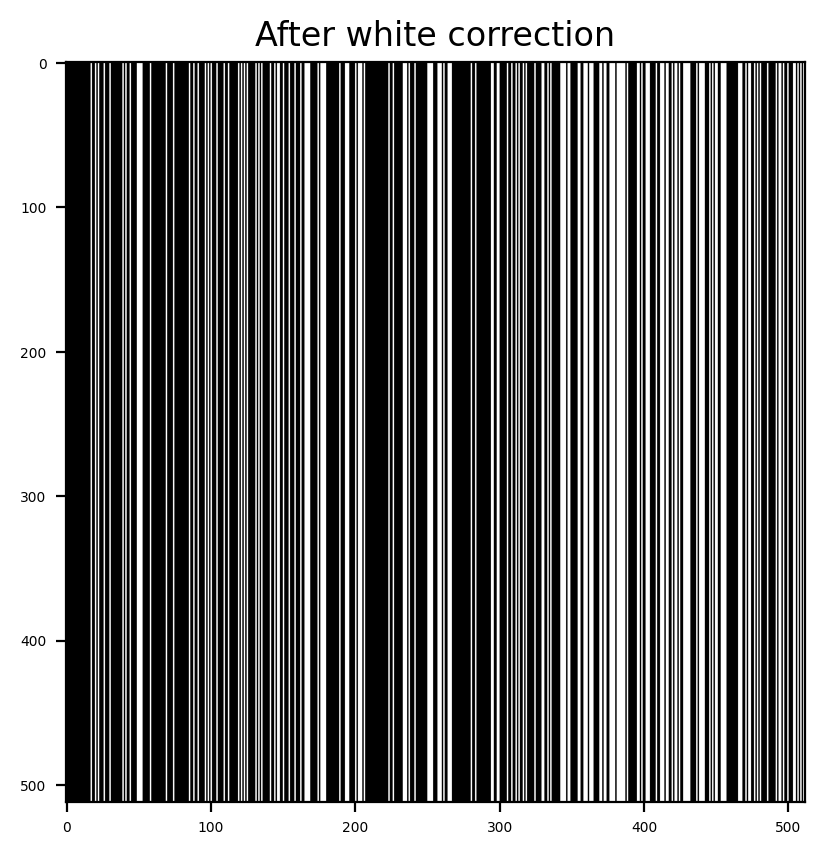

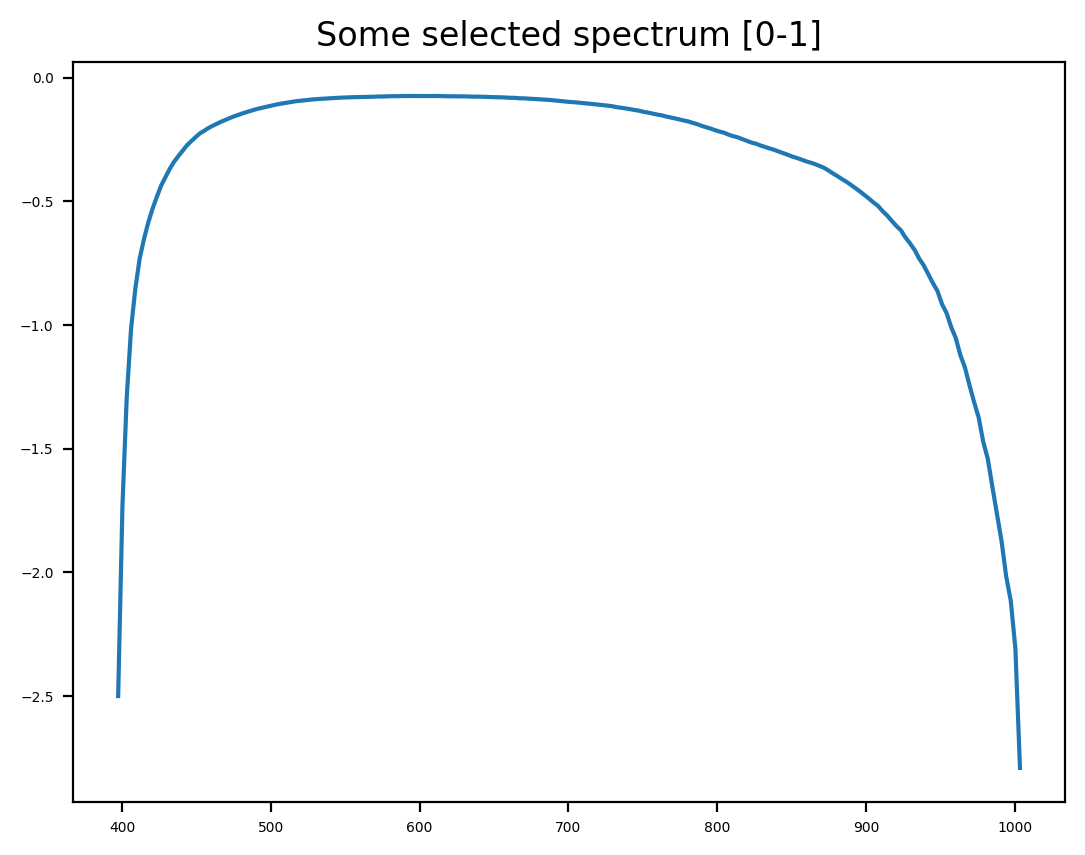

In [37]:
white_av = np.sum(white_image, axis = 0) # get average for White
dark_av = np.sum(dark_image, axis = 0) # get average for Dark

[lines, bands, samples] = spectral_cube.shape
print(spectral_cube.shape)
upper_part = np.zeros((lines, bands, samples), dtype=np.float32)
spectral_cube = np.zeros((lines, bands, samples), dtype=np.float32)
# Subtract [image - dark]
for i in range(lines):
  upper_part[i,:,:] = np.subtract(spectral_cube[i,:,:], dark_av) 
# Subtract [white - dark]
lower_part = np.subtract(white_av, dark_av) 
# Subtract [image devide [white-dark]]
for i in range(lines):
  spectral_cube[i,:,:] = np.divide(upper_part[i,:,:], lower_part)
# spectral_cube[:,:,:]  a white corrected spectral cube

plt.imshow(5*spectral_cube[:,100,:], cmap="gray")#, vmin=0, vmax= 1
plt.title("After white correction")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()
plt.plot(waves, spectral_cube[150,:,150])#
plt.title("Some selected spectrum [0-1]")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Band 80 wavelength 631.15
Band 46 wavelength 530.96
Band 16 wavelength 443.56


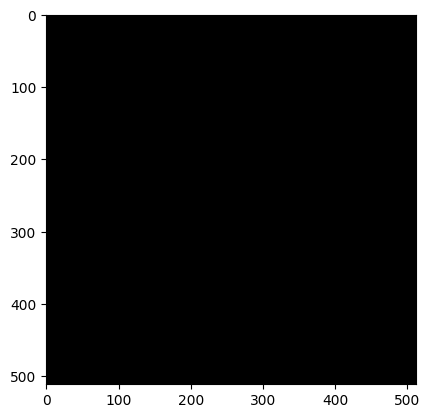

In [38]:
[s1,s2,s3] = spectral_cube.shape
RGBw = np.empty((s1, s3, 3)) # Create a 'bmp' array with spatial size of ENVI 512,512 with 3 layers
# We go to hdr file and select channels

w1,w2,w3 = 630,530,445
ch_1 = np.abs(np.asarray(waves)-w1).argmin() 
ch_2 = np.abs(np.asarray(waves)-w2).argmin()
ch_3 = np.abs(np.asarray(waves)-w3).argmin()

print('Band',ch_1,'wavelength', waves[ch_1])
print('Band',ch_2,'wavelength', waves[ch_2])
print('Band',ch_3,'wavelength', waves[ch_3])

RGBw[:,:,0] = spectral_cube[:,ch_1,:] 
RGBw[:,:,1] = spectral_cube[:,ch_2,:]
RGBw[:,:,2] = spectral_cube[:,ch_3,:]
plt.rcParams['figure.dpi'] = 100
plt.imshow(RGBw)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


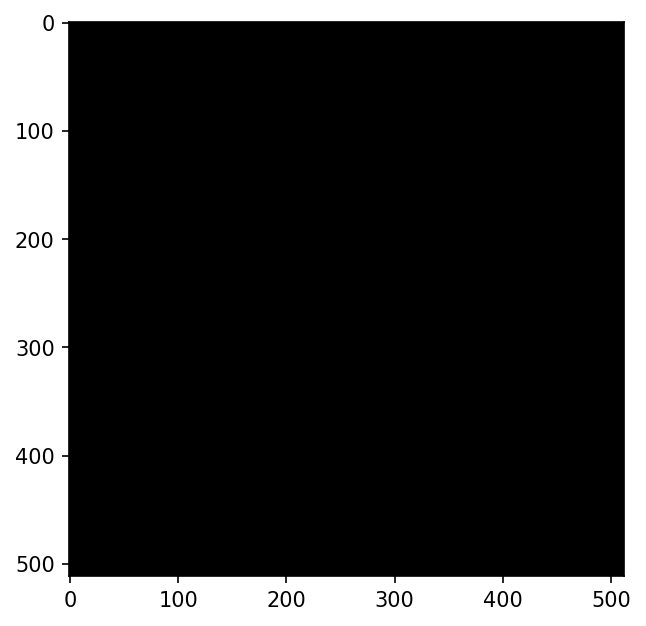

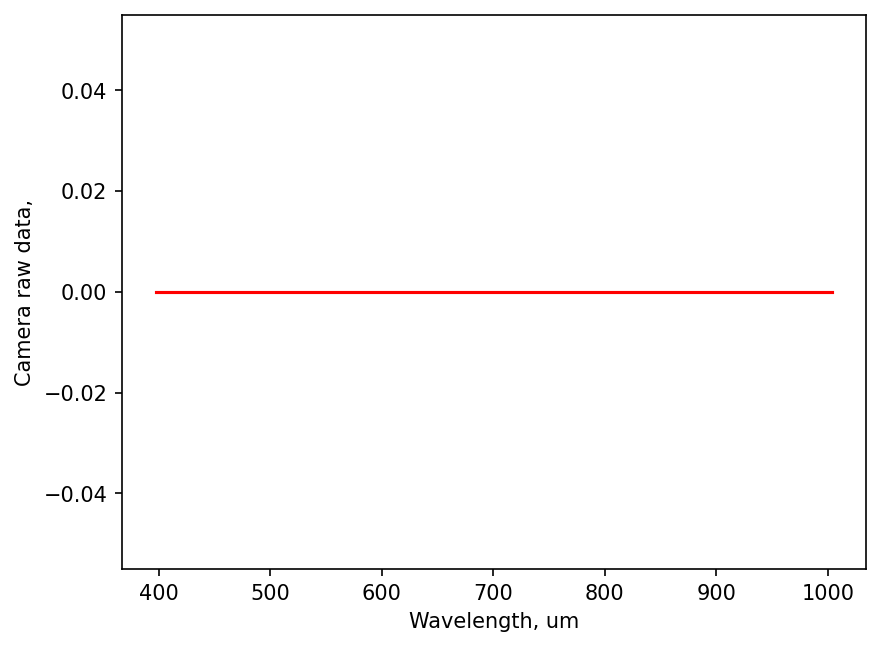

(512, 204, 512)


In [39]:
RGBm = RGBw.copy()
x1 = 530
x2 = 800
y1 = 1800
y2 = 2100
RGBm[y1:y2,x1:x2,0] = 0
RGBm[y1:y2,x1:x2,1] = 0
RGBm[y1:y2,x1:x2,2] = 0
sel = spectral_cube[y1:y2,:,x1:x2]
sel1 = np.sum(sel, axis = 0)
sample = np.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
##################################################################
plt.rcParams['figure.dpi'] = 150
plt.imshow(RGBm)
plt.show()



plt.plot(waves, sample, "red")
plt.rcParams['figure.dpi'] = 100
plt.xlabel('Wavelength, um')
plt.ylabel('Camera raw data,')
#plt.ylabel('Reflectance [0-100]%')
plt.show()
print(spectral_cube.shape)

512 204 512
52
69
86
103
120
136
153
RGB:  (512, 512, 3)
cube:  (512, 204, 512)
small cube:  (512, 512, 7)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.07447803
-0.14574346443017325
-0.0763334408402443


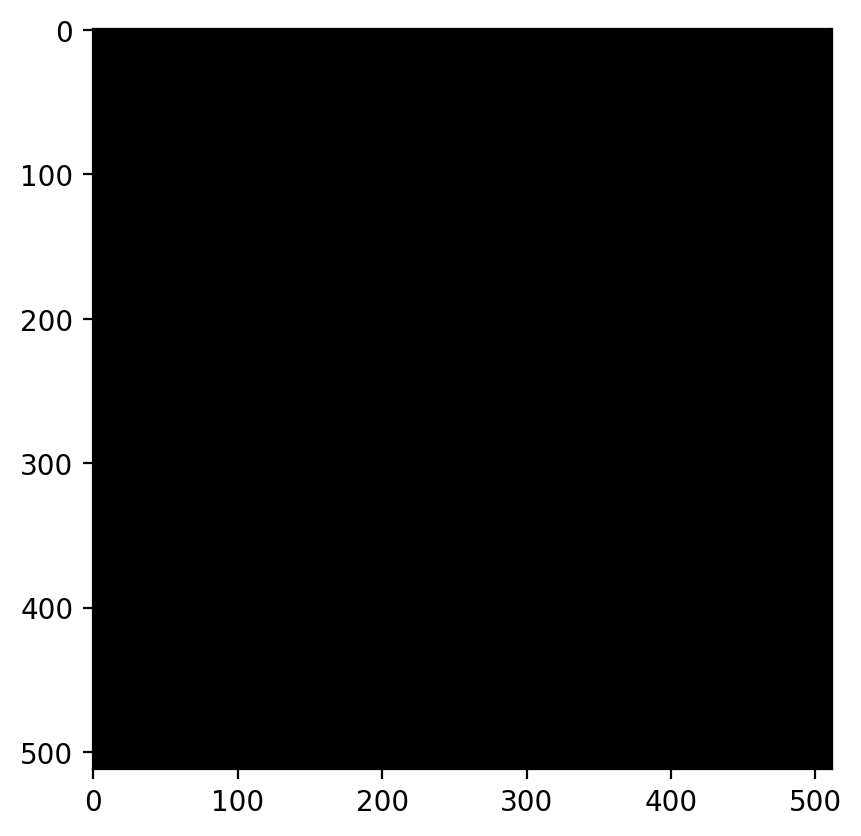

In [40]:
# Generate Band based condition
n = 7 # the number of important bnds
bands = np.empty(n, dtype=np.uint16) # array size of number of important bands
# we select the importqant bands:
w1=550
w2=600
w3=650
w4=700
w5=750
w6=800
w7=850
bands[0] = np.abs(np.asarray(waves)-w1).argmin() 
bands[1] = np.abs(np.asarray(waves)-w2).argmin()
bands[2] = np.abs(np.asarray(waves)-w3).argmin()
bands[3] = np.abs(np.asarray(waves)-w4).argmin() 
bands[4] = np.abs(np.asarray(waves)-w5).argmin()
bands[5] = np.abs(np.asarray(waves)-w6).argmin()
bands[6] = np.abs(np.asarray(waves)-w7).argmin()

# Read selected spectrum, ploted and saved in prevous code section 
# open_path = "/content/drive/MyDrive/mushrom_image0001.raw"
# fopen = open(open_path, "rb")
# selected = np.fromfile(fopen, dtype=np.float32) 
# fopen.close()
###################################################################################################
# ratio is an array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
ratio = np.zeros(n-1) # array of ratios: ratio[n]=selcted[bbands[n+1]]/selected[bbands[n]]
for i in range(n-1):
  ratio[i] = sample[bands[i]]
###################################################################################################
# now we make a new 'small_spectral_cube' made of selected bands from 'spectral_cube'
[s1, s2, s3] = spectral_cube.shape
print(s1, s2, s3)
small_spectral_cube = np.empty((lines, samples, n), dtype=np.float32)
i=0
for band in bands:
  small_spectral_cube[:,:,i] = spectral_cube[:,band,:]
  print(band)
  i=i+1
print('RGB: ', RGBw.shape)
print('cube: ', spectral_cube.shape)
print('small cube: ', small_spectral_cube.shape)

###################################################################################################
mask = RGBw.copy()

for i in range(0,s1):  #s1
  for j in range(0,s3): #s3
    criteria = 0
    for ch in range(n-1):
      #mask[i,j,0]=1
      if np.abs((small_spectral_cube[i,j,ch]-ratio[ch]))>0.1: #[0.02 - 0.18] threshold
        criteria = 1
        # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
        gray_color = (mask[i,j,0] + mask[i,j,1] + mask[i,j,2])/3 # make mask gray scale and only selection RGB
        mask[i,j,0]=gray_color
        mask[i,j,1]=gray_color
        mask[i,j,2]=gray_color                       
        # ´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´´
    if criteria == 0:
      pass

print(np.amax(small_spectral_cube))
print(np.amax(mask))
print(np.amax(RGBw))
###################################################################################################
# plt.rcParams['figure.dpi'] = 200
# plt.imshow(RGBw)

plt.show()
plt.rcParams['figure.dpi'] = 200
plt.imshow(mask)

plt.show()

## Task1_part 3_tunable

['green, ch 1, exp 31.3 ms.png', 'green, ch 2, exp 31.3 ms.png', 'green, ch 3, exp 31.3 ms.png', 'green, ch 4, exp 31.3 ms.png', 'green, ch 5, exp 31.3 ms.png', 'green, ch 6, exp 31.3 ms.png', 'green, ch 7, exp 31.3 ms.png', 'green, ch 8, exp 31.3 ms.png', 'green, ch 9, exp 31.3 ms.png', 'green, ch 10, exp 31.3 ms.png']
720 1280 10
(720, 10, 1280)


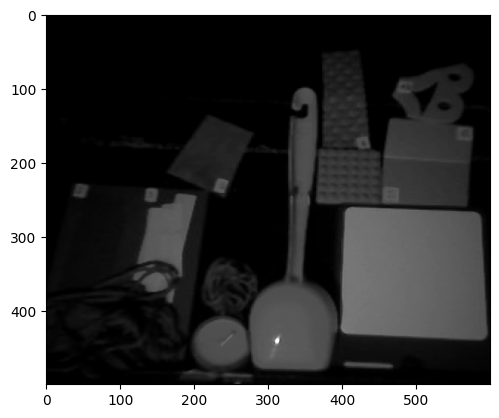

In [97]:

dirpath = "./[Tunable]"
myDir = os.listdir(dirpath)
# Read the first image define it size, define the total number of Images and get the size of future ENVI Spectral Cube
fullpath = os.path.join(dirpath, myDir[0])
im = Image.open(fullpath)
single_slice = np.array(im) # make a numpy array
[x, y] = single_slice.shape

choosen_exp=31.3
files = []
_file = None
for file in myDir:
    ch = int(file.split(',')[1].split(' ')[2])
    exp = float(file.split(',')[2].split(' ')[2])
    if exp == choosen_exp:
        if ch == 10:
            _file = file
        else:
            files.append(file)
files = sorted(files)
files.append(_file)
print(files)

spectral = len(files)
print(x, y, spectral)



# save as integers, data type = 12
corr_spectral_cube = np.ndarray(shape=(x,spectral,y), dtype=np.uint16)
print(corr_spectral_cube.shape)







i=0
for file in files:
  fullpath = os.path.join(dirpath, file)
  im = Image.open(fullpath) 
  single_slice = np.array(im)
  #print(imarray.shape)
  corr_spectral_cube[:,i,:]=single_slice
  i = i + 1

# spectral_cube.tofile('nuance.raw')
# Save ready ENVI cube made of tiffs
plt.rcParams['figure.dpi'] = 100
corr_spectral_cube = corr_spectral_cube[100:600,:,250:850]
plt.imshow(corr_spectral_cube[:,9,:], cmap='gray') #, vmin=0, vmax=3138


(500, 600, 3)
(500, 10, 600)


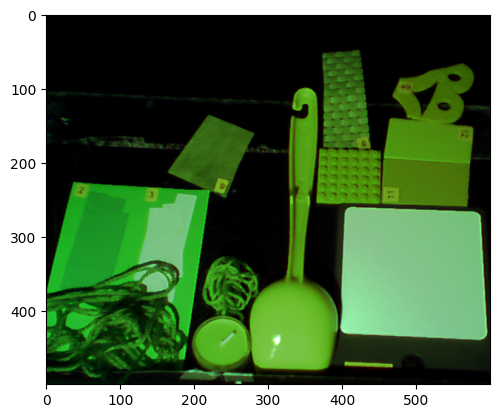

In [108]:
lines,_, samples = corr_spectral_cube.shape 
RGB = np.empty((lines, samples, 3)) 
# w1,w2,w3 = 620,550,440
# ch_1 = np.abs(np.asarray(waves)-w1).argmin() 
# ch_2 = np.abs(np.asarray(waves)-w2).argmin()
# ch_3 = np.abs(np.asarray(waves)-w3).argmin()
ch_1=8
ch_2=4
ch_3=1
# print('Band',3,'wavelength', waves[ch_1])
# print('Band',6,'wavelength', waves[ch_2])
# print('Band',9,'wavelength', waves[ch_3])
print(RGB.shape)
print(corr_spectral_cube.shape)


RGB[:,:,0] = corr_spectral_cube[:,ch_1,:] /np.amax(corr_spectral_cube[:,ch_1,:]) # we get RGB in range [0,1], normalized
RGB[:,:,1] = corr_spectral_cube[:,ch_2,:] /np.amax(corr_spectral_cube[:,ch_2,:])
RGB[:,:,2] = corr_spectral_cube[:,ch_3,:] /np.amax(corr_spectral_cube[:,ch_3,:])

# RGB[:,:,0] = spectral_image[:,ch_1,:] 
# RGB[:,:,1] = spectral_image[:,ch_2,:] 
# RGB[:,:,2] = spectral_image[:,ch_3,:] 


plt.imshow(RGB)
plt.show()

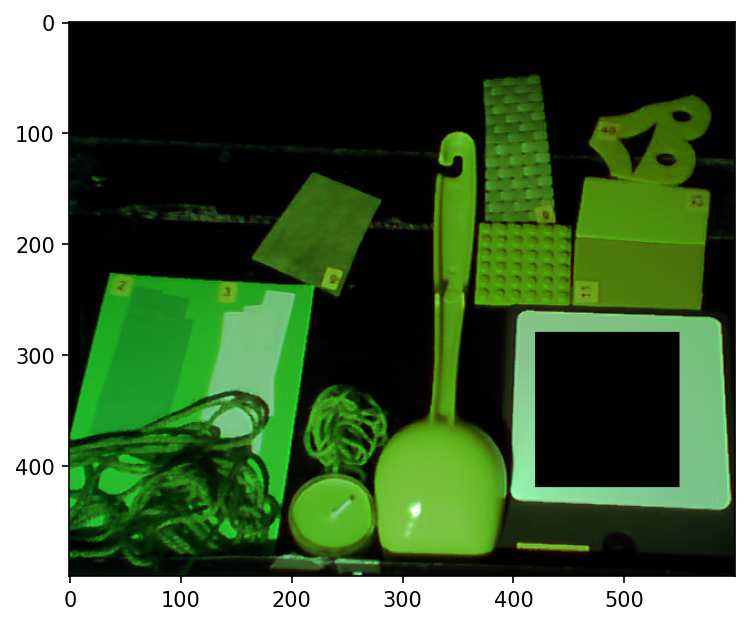

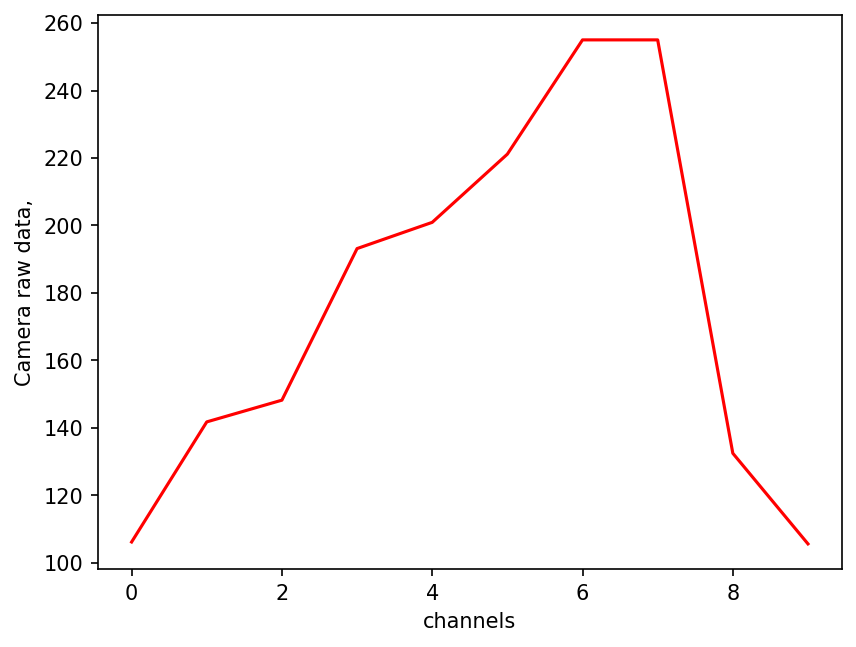

In [111]:
x1 = 420
x2 = 550
y1 = 280
y2 = 420

RGB[y1:y2,x1:x2,0] = 0
RGB[y1:y2,x1:x2,1] = 0
RGB[y1:y2,x1:x2,2] = 0
sel = corr_spectral_cube[y1:y2,:,x1:x2]
sel1 = np.sum(sel, axis = 0)
white_p = np.sum(sel1, axis =1)/((x2-x1)*(y2-y1))
plt.rcParams['figure.dpi'] = 150
plt.imshow(RGB)
plt.show()


# wa = [0,1,2,3,4,5,6,7,8,9]

plt.plot(white_p, "red")

plt.xlabel('channels')
plt.ylabel('Camera raw data,')
#plt.ylabel('Reflectance [0-100]%')
plt.show()

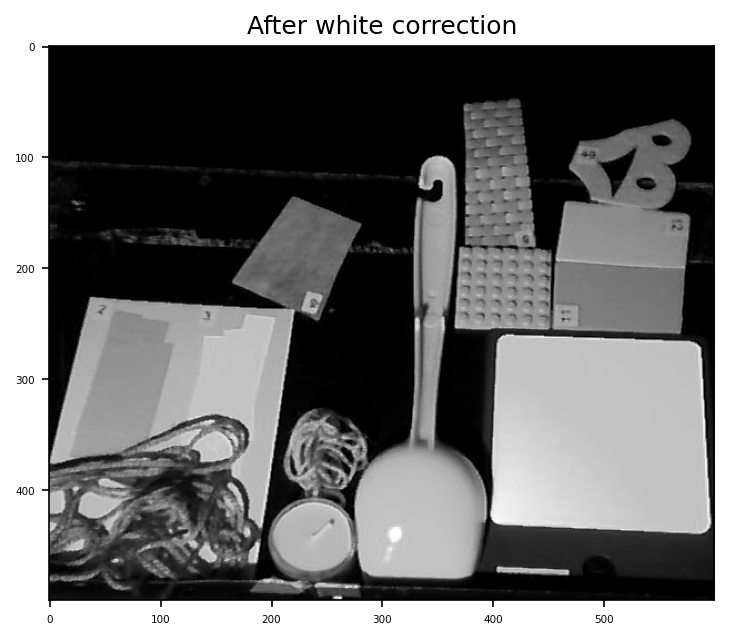

In [113]:
corr_spectral_cube = np.transpose(corr_spectral_cube, (0, 2, 1)) # rotating 90 derees
corr_spectral_cube = corr_spectral_cube/ white_p
# corr_spectral_cube = spectral_image/ white_p [:,np.newaxis] 
# # spectral_cube[:,:,:]  a white corrected spectral cube
lines,_, samples = corr_spectral_cube.shape 
RGBw = np.empty((lines, samples, 3)) 
# w1,w2,w3 = 620,550,440
# ch_1 = np.abs(np.asarray(waves)-w1).argmin() 
# ch_2 = np.abs(np.asarray(waves)-w2).argmin()
# ch_3 = np.abs(np.asarray(waves)-w3).argmin()
ch_1=8
ch_2=4
ch_3=1
# print('Band',3,'wavelength', waves[ch_1])
# print('Band',6,'wavelength', waves[ch_2])
# print('Band',9,'wavelength', waves[ch_3])
print(RGBw.shape)
print(corr_spectral_cube.shape)


RGBw[:,:,0] = corr_spectral_cube[:,ch_1,:] 
RGBw[:,:,1] = corr_spectral_cube[:,ch_2,:] 
RGBw[:,:,2] = corr_spectral_cube[:,ch_3,:] 

plt.imshow(5*corr_spectral_cube[:,:,4], cmap="gray")#, vmin=0, vmax= 1
plt.title("After white correction")
plt.tick_params(axis='both', which='major', labelsize=5)
plt.show()

